# Shapes, layers, and photonic crystals

In [1]:
import numpy as np
import legume

%load_ext autoreload
%autoreload 2

## Shapes and layers

Shapes and layers are the basic building blocks of a simulation in `legume`. A layer can contain any number of shapes. A layer is the fundamental object for the plane-wave expansion, while a photonic crystal made up of a number of layers is the fundamental object for the guided-mode expansion. Initializing a `ShapesLayer` class requires one positional argument `lattice`, which is an instance of the `Lattice` object. Let's start by creating a lattice, a layer, and some shapes.

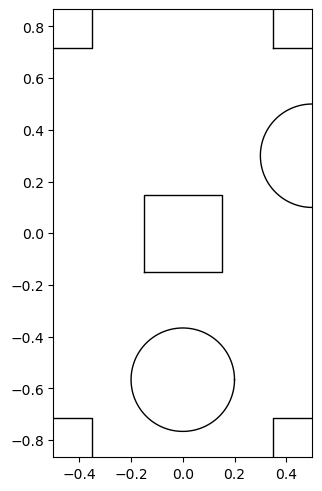

In [2]:
# Initialize a lattice (can be 'square', 'hexagonal', or defined by primitive vectors)
lattice = legume.Lattice('hexagonal')

# Initialize a layer with background permittivity 2
layer = legume.ShapesLayer(lattice, eps_b=2) 

# Create a square and use the `add_shape` method to add it to the layer
square = legume.Square(eps=10, x_cent=0, y_cent=0, a=0.3)
layer.add_shape(square)

# Create a circle and also add it to the layer 
circle = legume.Circle(eps=6, x_cent=0.5, y_cent=0.3, r=0.2)
layer.add_shape(circle)

# Use an in-built visualization method to plot the contours of the shapes we have so far
legume.viz.shapes(layer)

Notice how the shapes are repeated in a `hexagonal` pattern, following the way we initialized our `lattice`. The above plot shows the shapes, but not the permittivity distribution. To see that, we can use another built-in method. 

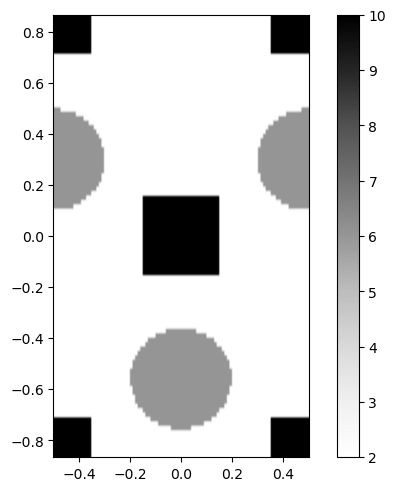

In [3]:
legume.viz.eps(layer, cbar=True)

## Plane-wave expansion
The layer we consturcted can now be used to initialize a plane-wave expansion simulation. This also takes two keyword arugments:

- `gmax`      : Maximum reciprocal lattice wave-vector length in units of $2\pi/a$
- `eps_eff`   : Effective background epsilon; if None, take layer.eps_b. Setting this to a different value can be useful for simulations of an effective slab of a given thickness and at a particular frequency.

In [4]:
pwe = legume.PlaneWaveExp(layer, gmax=3)

We can plot the permittivity as "seen" by the PWE with a given gmax; in other words, we can plot the real-space permittivity from the Fourier components that will be used in the expansion. Notice how this gets closer to the real structure as gmax increases.

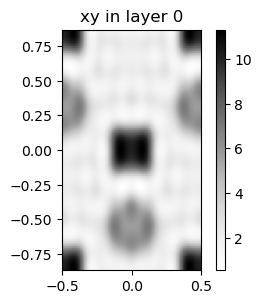

In [5]:
legume.viz.eps_ft(pwe, figsize=2.5)

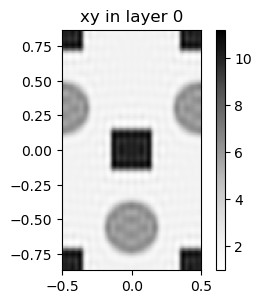

In [6]:
pwe = legume.PlaneWaveExp(layer, gmax=6)
legume.viz.eps_ft(pwe, figsize=2.5)

We will not run the simulation here; this tutorial is only oriented towards building the simulation structures.

## Photonic crystals

We can build photonic crystals made of one or more layers, and add various shapes. Let's start with an example.

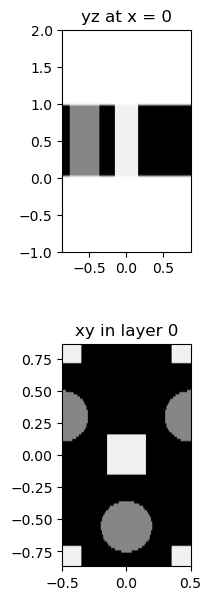

In [7]:
# Initialize a lattice (can be 'square', 'hexagonal', or defined by primitive vectors)
lattice = legume.Lattice('hexagonal')

# Initialize a PhC (optional kwargs are the permittivity in the lower and upper cladding)
phc = legume.PhotCryst(lattice, eps_l=1., eps_u=1.)

# Add a layer to the PhC with thickness 1 and background permittivity 10
phc.add_layer(d=1, eps_b=10)

# We can add shapes to the layer in two different ways:

# Create a square and use the layer `add_shape` method
square = legume.Square(x_cent=0, y_cent=0, a=0.3, eps=2)

# Create a circle and use the phc `add_shape` method
circle = legume.Circle(eps=6, x_cent=0.5, y_cent=0.3, r=0.2)
phc.add_shape([circle, square]) # by default added to the last layer; can add a list of shapes

# We can plot an overview of what we've built so far
legume.viz.structure(phc, yz=True, figsize=2., cbar=False)

## Guided-mode expansion
Just like PWE, GME uses the Fourier transform (FT) of the shapes. The `GuidedModeExp` object also takes `gmax` as a keyword argument, and we can also plot the FT of the photonic crystal that we're simulating.

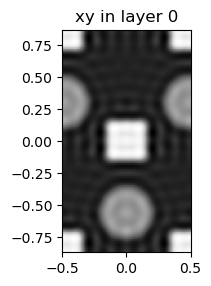

In [8]:
gme = legume.GuidedModeExp(phc, gmax=5)
legume.viz.eps_ft(gme, figsize=2., cbar=False)

## Multiple layers and fancy shapes

We can also create and simulate a multi-layer structure!

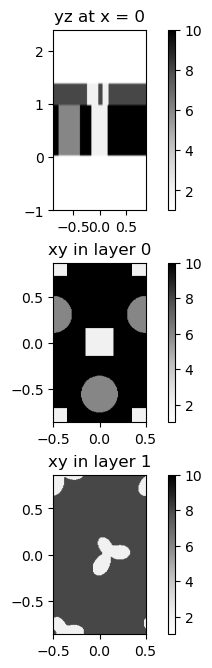

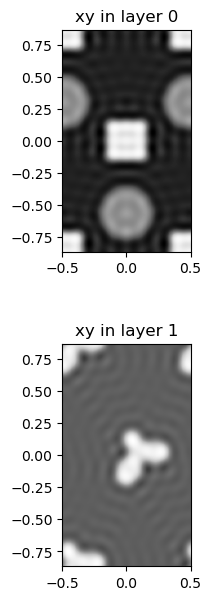

In [9]:
# Add another layer to our existing photonic crystal
phc.add_layer(d=0.4, eps_b=8)

# Add a FourierShape which is defined by the Fourier components of R(phi) in polar coordinates
# (see documentation)
fshape = legume.FourierShape(x_cent=0.1, eps=2, 
            f_as=np.array([0.3, 0., 0., 0.08]), f_bs=np.array([0., 0.04]))
phc.add_shape(fshape) # always adds to the last layer

# Visualize the structure and compare to the FT
legume.viz.structure(phc, Ny=300, yz=True, figsize=2., cbar=True)
gme = legume.GuidedModeExp(phc, gmax=5)
legume.viz.eps_ft(gme, Ny=300, figsize=2., cbar=False)

## Shapes in the claddings
You can add shapes to the claddings too!

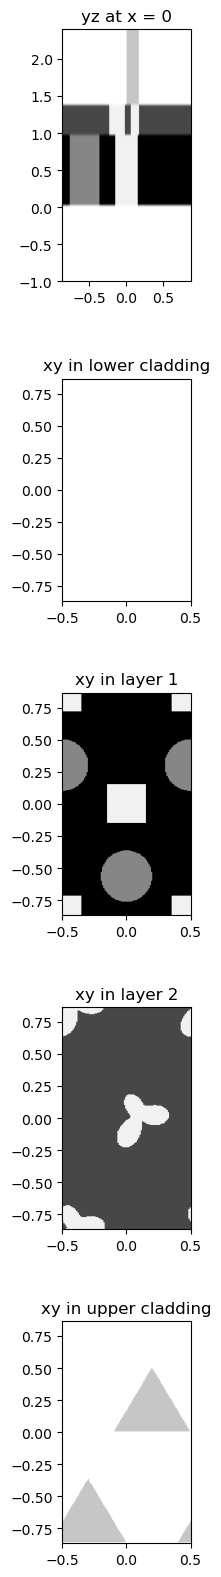

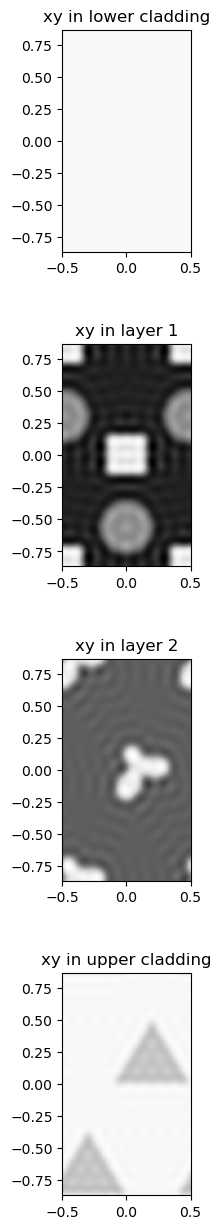

In [10]:
triangle = legume.Poly(x_edges=[-0.1, 0.5, 0.2], y_edges=[0, 0, 0.5], eps=4)
phc.add_shape(triangle, cladding=1) # you can also say cladding = 'l', or phc.cladding[0].add_shape(triangle)

# Plot the real-space overview
legume.viz.structure(phc, Ny=300, cladding=True, yz=True, figsize=2., cbar=False)
gme = legume.GuidedModeExp(phc, gmax=5)
legume.viz.eps_ft(gme, Ny=300, cladding=True, figsize=2., cbar=False)

## Caveats

Some important things to keep in mind:
- Polygons should be defined such that the points circle their interior in a counter-clockwise manner. But don't worry, if you don't do that you'll get a warning telling you to do it.
- FourierShape shapes should spit out an error if `R(phi)` is < 0 for some `phi`. If you're running optimizations, you should bound the parameters for this to not happen.
- *Shapes should not overlap.* This might be fixed in the future, but right now here's what happens if they do (notice the discrepancy between the direct visualization and the one from inverse FT): 

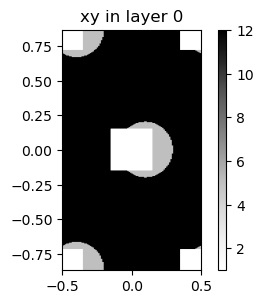

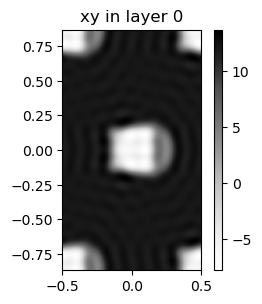

In [11]:
phc = legume.PhotCryst(lattice)
phc.add_layer(d=1, eps_b=12)
circle = legume.Circle(x_cent=0.1, r=0.2, eps=5)
square = legume.Square(a=0.3)
phc.add_shape([circle, square]) 

# Notice the discrepancy between the two plots. In the FT, the permittivity of the overlapping shapes is wrong -
# and so the simulation will be wrong!
legume.viz.structure(phc, Ny=300, figsize=2.5)
gme = legume.GuidedModeExp(phc, gmax=5)
legume.viz.eps_ft(gme, Ny=300, figsize=2.5)